In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier

import warnings
warnings.filterwarnings('ignore')

import time

# %matplotlib inline: make it able to show graphics without 'plt.show()'
%matplotlib inline

# show progress bar
tqdm.pandas()

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [4]:
print(f'Sum of duplicated:{train.duplicated().sum()} ')
print(f'Null value for each col:{train.isnull().sum().values}')

Sum of duplicated:0 
Null value for each col:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
X = train.drop(columns=['smoking', 'id'])
y = train['smoking']

In [6]:
X.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')

In [7]:
# 下面的函数将打印每列的名称，以及其偏度和峰度
def print_skewness_kurtosis(df, skew_threshold=0.5, kurt_threshold=3):
    skewed_features = []
    for column in df.columns:
        skewness = df[column].skew()
        kurtosis = df[column].kurtosis()

        print(f"{column}: Skewness = {skewness}, Kurtosis = {kurtosis}\n")
        if abs(skewness) > skew_threshold or abs(kurtosis) > kurt_threshold:
            skewed_features.append(column)
    return skewed_features

skewed_features=print_skewness_kurtosis(X)
# skewed_features=print_skewness_kurtosis(X_transformed)

age: Skewness = 0.2916973461458878, Kurtosis = -0.15879716308708014

height(cm): Skewness = -0.2699148051800865, Kurtosis = -0.5307732813493358

weight(kg): Skewness = 0.37807475043098937, Kurtosis = -0.03657627191245183

waist(cm): Skewness = 0.07244589379014092, Kurtosis = -0.05641096663642742

eyesight(left): Skewness = 8.890572430701148, Kurtosis = 196.4654686805755

eyesight(right): Skewness = 8.486849095554883, Kurtosis = 192.72934663210577

hearing(left): Skewness = 6.2239202761990695, Kurtosis = 36.737644970237824

hearing(right): Skewness = 6.302436824084392, Kurtosis = 37.721183638999484

systolic: Skewness = 0.21992481204281342, Kurtosis = 0.21205237030470858

relaxation: Skewness = 0.17634977480941716, Kurtosis = 0.14220138990160525

fasting blood sugar: Skewness = 3.461099039475446, Kurtosis = 27.200003632838072

Cholesterol: Skewness = 0.043487788578322334, Kurtosis = -0.20628096571151744

triglyceride: Skewness = 0.986227749457496, Kurtosis = 0.9961084484958342

HDL: Ske

In [8]:
print(skewed_features)

['eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'fasting blood sugar', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']


In [9]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
cols_to_encode = [col for col in categorical_cols if train[col].nunique() > 1]
print("Columns need to be one-hot encoded:", cols_to_encode)

Columns need to be one-hot encoded: []


In [10]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
cols_to_scale = [col for col in numerical_cols if train[col].var() > 1]
print(f"Columns need to be standardized:\n{cols_to_scale}")

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(X_scaled[cols_to_scale])
X_encoded = pd.get_dummies(train, columns=cols_to_encode)
print(X_encoded.head())

Columns need to be standardized:
['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'AST', 'ALT', 'Gtp']
   id  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0   55         165          60       81.0             0.5   
1   1   70         165          65       89.0             0.6   
2   2   20         170          75       81.0             0.4   
3   3   35         180          95      105.0             1.5   
4   4   30         165          60       80.5             1.5   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...  HDL  LDL  \
0              0.6              1               1       135  ...   40   75   
1              0.7              2               2       146  ...   57  126   
2              0.5              1               1       118  ...   45   93   
3              1.2              1               1       131  ...   38  102   
4       

Train models

Prepare pipeline

In [11]:
# from scipy.special import boxcox1p
# from scipy.stats import yeojohnson
# def apply_transformation(X, skewed_features, method='yeojohnson'):
#     X_transformed = X.copy()
#     for feature in skewed_features:
#         if method == 'boxcox':
#             # 对于boxcox，所有数据必须是正的，如果有非正数据，可以加上一个正的常数
#             # 如果数据中有零或负值，Box-Cox 变换可能不适用
#             # Box-Cox 只能用于连续且大于0的数据
#             X_transformed[feature], _ = boxcox1p(X[feature], 0.15)
#         elif method == 'yeojohnson':
#             # Yeo-Johnson 可以用于正值和零（包括负值）
#             X_transformed[feature], _ = yeojohnson(X[feature])
#     return X_transformed
# X_transformed = apply_transformation(X, skewed_features, method='yeojohnson')  # 或 'boxcox'
# X_transformed
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.special import boxcox1p
from scipy.stats import yeojohnson

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='yeojohnson', skewed_features=None):
        self.method = method
        self.skewed_features = skewed_features

    def transform(self, X, y=None):
        X_transformed = X.copy()
        if self.skewed_features is None:
            self.skewed_features = X.columns
        for feature in self.skewed_features:
            if self.method == 'boxcox':
                # 对于boxcox，所有数据必须是正的
                X_transformed[feature], _ = boxcox1p(X[feature], 0.15)
            elif self.method == 'yeojohnson':
                # Yeo-Johnson 可以用于正值和零（包括负值）
                X_transformed[feature], _ = yeojohnson(X[feature])
        return X_transformed


In [12]:
# stand_tran = make_pipeline(CustomTransformer(method='yeojohnson', skewed_features=skewed_features))
stand_tran = make_pipeline(PowerTransformer())

processor = make_column_transformer(
    (stand_tran, skewed_features),
    remainder='passthrough'
)

In [13]:
processor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('powertransformer',
                                                  PowerTransformer())]),
                                 ['eyesight(left)', 'eyesight(right)',
                                  'hearing(left)', 'hearing(right)',
                                  'fasting blood sugar', 'triglyceride', 'HDL',
                                  'LDL', 'hemoglobin', 'Urine protein',
                                  'serum creatinine', 'AST', 'ALT', 'Gtp',
                                  'dental caries'])])

KNN

In [14]:
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 1)
knn_cv_routine = cross_val_score(make_pipeline(processor, KNeighborsClassifier(n_neighbors = 220)),
                                 X,
                                 y,
                                 scoring = 'roc_auc',
                                 cv = skf,
                                 n_jobs = -1)
print(f"The average oof ROC-AUC score of the k-NN model is {knn_cv_routine.mean()}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The average oof ROC-AUC score of the k-NN model is 0.7932763230543325


In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
poly_tran = make_pipeline(PolynomialFeatures(2, include_bias = False), StandardScaler())

proccessor = make_column_transformer(
    (poly_tran, (skewed_features)), 
    remainder = 'passthrough')

LDA = make_pipeline(proccessor, LinearDiscriminantAnalysis())
LDA

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['eyesight(left)',
                                                   'eyesight(right)',
                                                   'hearing(left)',
                                                   'hearing(right)',
                                                   'fasting blood sugar',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'Urine protein',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp',
                                                   'dental caries'])])),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

In [16]:
LDA_cv_routine = cross_val_score(LDA,
                                 X,
                                 y,
                                 scoring = 'roc_auc',
                                 cv = skf,
                                 n_jobs = -1)

print(f"The average oof ROC-AUC score of the LDA model is {LDA_cv_routine.mean()}")

The average oof ROC-AUC score of the LDA model is 0.8412753202106289


In [17]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
logit = make_pipeline(proccessor, LogisticRegression(C = 0.1, 
                                                     max_iter = 2000, 
                                                     solver = 'newton-cholesky'))

Logit_cv_routine = cross_val_score(logit,
                                   X,
                                   y,
                                   scoring = 'roc_auc',
                                   cv = skf,
                                   n_jobs = -1)

print(f"The average oof ROC-AUC score of the Logistic model is {Logit_cv_routine.mean()}")

The average oof ROC-AUC score of the Logistic model is 0.8434286061235318


In [18]:
from sklearn.ensemble import RandomForestClassifier
RF_cv_routine = cross_val_score(RandomForestClassifier(criterion = 'log_loss',
                                                       n_estimators = 200,
                                                       max_features = 10,
                                                       min_samples_leaf = 15,
                                                       random_state = 1), 
                                X,
                                y,
                                scoring = 'roc_auc',
                                cv = skf, 
                                n_jobs = -1)

print(f"The average oof ROC-AUC score of the RF model is {RF_cv_routine.mean()}")

KeyboardInterrupt: 

In [ ]:
ET_cv_routine = cross_val_score(ExtraTreesClassifier(criterion = 'log_loss',
                                                     n_estimators = 200,
                                                     min_samples_leaf = 15, 
                                                     max_features = 10,
                                                     random_state = 1), 
                                X,
                                y,
                                scoring = 'roc_auc',
                                cv = skf, 
                                n_jobs = -1)

print(f"The average oof ROC-AUC score of the ET model is {ET_cv_routine.mean()}")

In [19]:
from xgboost import XGBClassifier
XGB_cv_routine = cross_val_score(XGBClassifier(tree_method = 'hist',
                                               n_estimators = 600,
                                               learning_rate = 0.1,
                                               colsample_bytree = 0.5), 
                                 X,
                                 y,
                                 scoring = 'roc_auc',
                                 cv = skf, 
                                 n_jobs = -1)

print(f"The average oof ROC-AUC score of the XGB model is {XGB_cv_routine.mean()}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The average oof ROC-AUC score of the XGB model is 0.870356081521327


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=1)

In [26]:
xgb_model=XGBClassifier(tree_method = 'hist',
                    n_estimators = 600,
                    learning_rate = 0.1,
                    colsample_bytree = 0.5)

xgb_model.fit(X_train, y_train)
# xgb_pred=xgb_model.predict_proba(X_test)[:, 1]

test_features=test.drop(columns=['id'])
# predictions = xgb_model.predict(test_features)
predictions = xgb_model.predict_proba(test_features)[:, 1]

sub = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
sub['smoking'] =  predictions
sub.to_csv('submission.csv',index=False)
sub.head()

,id,smoking
0,159256,0.659982
1,159257,0.241483
2,159258,0.455094
3,159259,0.017582
4,159260,0.616890


RandomForestClassifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

def do_RandomForestClassifier():
    model = RandomForestClassifier(n_estimators=100, random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    
    # 获取特征重要性
    importances = model.feature_importances_
    # 返回每个特征的重要性排序的索引
    indices = np.argsort(importances)[::-1]
    # 绘制特征重要性
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
           color="r", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    
# do_RandomForestClassifier()

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score

def find_best_features_for_RandomForestClassifier():
    # 用于存储不同k值下的平均交叉验证得分
    mean_scores = []

    # 特征数量
    total_features = X_train.shape[1]

    # 从1到total_features尝试每个k值
    for k in tqdm(range(1, total_features + 1), desc="Selecting Best Features"):
        # 应用SelectKBest算法选择k个最佳特征
        selector = SelectKBest(f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)

        # 创建一个新的随机森林分类器
        model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)

        # 使用交叉验证评估模型性能
        scores = cross_val_score(model, X_train_selected, y_train, cv=5)
        mean_scores.append(scores.mean())

    # 绘制k值和交叉验证得分的图像
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, total_features + 1), mean_scores, marker='o')
    plt.xlabel('Number of Features Selected')
    plt.ylabel('Cross-Validated Accuracy Score')
    plt.title('Feature Selection vs. Model Accuracy')
    plt.show()
    
# find_best_features_for_RandomForestClassifier()

XGBClassifier

Accuracy: 0.7793231194273516


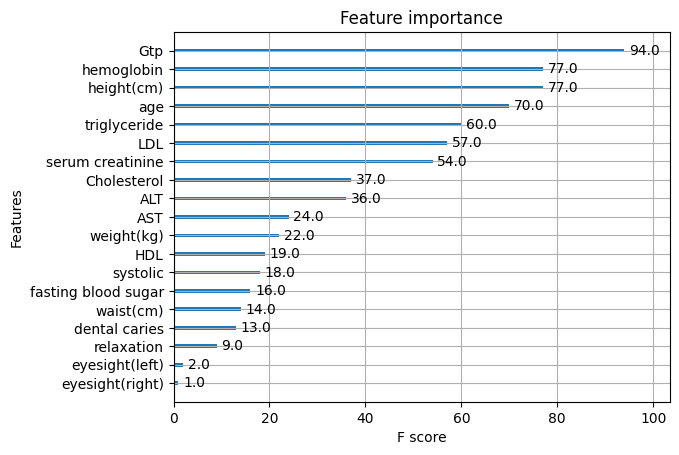

In [23]:
from xgboost import XGBClassifier
from xgboost import plot_importance

def do_XGBClassifier():
    xgb_clf = XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        max_depth=3,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist')
    xgb_clf.fit(X_train, y_train)

    y_pred = xgb_clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    plot_importance(xgb_clf)
    plt.show()
    
    return xgb_clf
    

XGB_model = do_XGBClassifier()

In [19]:
from sklearn.model_selection import StratifiedKFold

def do_XGBClassifier_k_fold():
    xgb_clf = XGBClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        max_depth=3,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='gpu_hist')
    
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)
    accuracies = []
    
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
        xgb_clf.fit(X_train_fold, y_train_fold)

        y_pred_fold = xgb_clf.predict(X_test_fold)

        accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
        accuracies.append(accuracy_fold)
        print(f"Accuracy = {train_index}: {accuracy_fold}")
    average_accuracy = np.mean(accuracy_fold)
    print(f"Average Accuracy: {average_accuracy}")
do_XGBClassifier_k_fold()

Accuracy = [     0      1      2 ... 159251 159252 159253]: 0.7741429109632049
Accuracy = [     0      3      4 ... 159253 159254 159255]: 0.7735078961414085
Accuracy = [     0      1      2 ... 159253 159254 159255]: 0.7781231358513077
Accuracy = [     1      2      4 ... 159251 159254 159255]: 0.7767103073686854
Accuracy = [     0      1      2 ... 159253 159254 159255]: 0.7725346142978242
Average Accuracy: 0.7725346142978242


In [33]:
test_features=test.drop(columns=['id'])
predictions = XGB_model.predict(test_features)
predictions

array([0, 0, 1, ..., 1, 0, 0])

In [34]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')
sub['smoking'] =  predictions
sub.to_csv('submission.csv',index=False)
sub.head()

,id,smoking
0,159256,0
1,159257,0
2,159258,1
3,159259,0
4,159260,1
